In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import zipfile 

2021-12-09 18:59:57.470759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mosobhy/.local/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-09 18:59:57.470826: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [35]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

In [21]:
current_path = '/home/mosobhy/machine_learning/Cancer Detection/Task 1/Histopathologic cancer detection/'
train_path = current_path + 'train_labels.csv'

train_dir = current_path + 'train/'
test_dir = current_path + 'test/'

# load the training data
train = pd.read_csv(train_path, dtype='str')
# make the label value integer
train['label'] = train['label'].astype('uint8')

# add the images extensions
train['id'] = train['id']+ '.tif'
print(len(train))
train.head(5)

220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


The image shape:  (32, 32, 3)


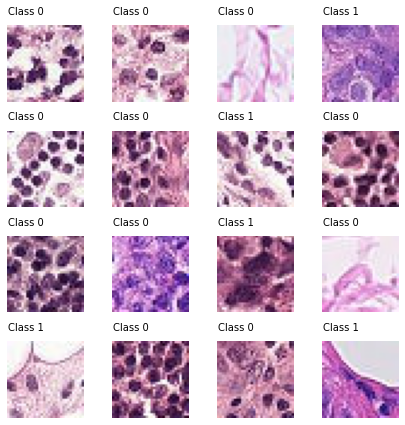

In [22]:
# view sample data
sample = train.sample(n=16).reset_index()
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i, row in sample.iterrows():  
    # a (96, 96, 3) image shape
    img = mpimg.imread(f'{train_dir}{row.id}')
    label = row.label
    plt.subplot(4,4,i+1)    # the number of images in the grid is 6*6 (16)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')

print('The image shape: ', img.shape)
plt.tight_layout()
plt.show()

In [23]:
# display the count of the two classes
print('1 classes: ', len(train[train['label'] == 1]))
print('0 classes: ', len(train[train['label'] == 0]))

# so the data is biased to the 0 class
# make a balance between these two classes
sample_size = 5000

train_0 = train[train['label'] == 0].sample(sample_size, random_state=1)
train_1 = train[train['label'] == 1].sample(sample_size, random_state=1)

# now lets merge the two classes again into the same training set
train_set = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)

# shuffle the data
train = shuffle(train_set)

train['label'].value_counts()

1 classes:  89117
0 classes:  130908


1    5000
0    5000
Name: label, dtype: int64

In [24]:
# read the training data
train_df = []
labels_df = []

for _, img_path, label in train.itertuples():
    image = cv2.imread(train_dir + img_path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    train_df.append(image)
    labels_df.append(label)

train_df = np.array(train_df)
labels_df = np.array(labels_df)

print(type(train_df))
print(type(labels_df))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df,
    labels_df,
    test_size=0.2,
    random_state=1
)

# normalize the images
X_train, X_test = X_train / 255.0, X_test / 255.0

In [36]:
# get the vgg16 model ready
input_shape = (32, 32, 3)
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_model.summary()

80150528/80134624 [==============================] - 97s 1us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                             

In [37]:
# freeze the convolution layers to harness the already calculated weights
for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [38]:
# using the vgg16 pre-trained model to get the low and high level features for our training and testing data
X_train_features = vgg_model.predict(X_train)
X_train_fets = X_train_features.reshape(X_train_features.shape[0], -1)

X_test_features = vgg_model.predict(X_test)
X_test_fets = X_test_features.reshape(X_test_features.shape[0], -1)

print('training shape: ', X_train_fets.shape)
print('test shape: ', X_test_fets.shape)

2021-12-09 19:40:35.998455: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 98304000 exceeds 10% of free system memory.


training shape:  (8000, 512)
test shape:  (2000, 512)


In [39]:
# train a the SVM model and evaluate the accurecy
model = None
svm_clf = svm.LinearSVC()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42, max_leaf_nodes=16, n_jobs=-1)
log_clf = LogisticRegression()
pre_clf = Perceptron() 

model = log_clf

model.fit(X_train_fets, y_train)

predictions = model.predict(X_test_fets)


# Compute how well we performed
correct = (y_test.reshape(-1) == predictions).sum()
incorrect = (y_test.reshape(-1) != predictions).sum()
total = len(predictions)

# Print results
print(f"Results for model {type(model).__name__}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Accuracy: {100 * correct / total:.2f}%")

Results for model LogisticRegression
Correct: 1541
Incorrect: 459
Accuracy: 77.05%


/home/mosobhy/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


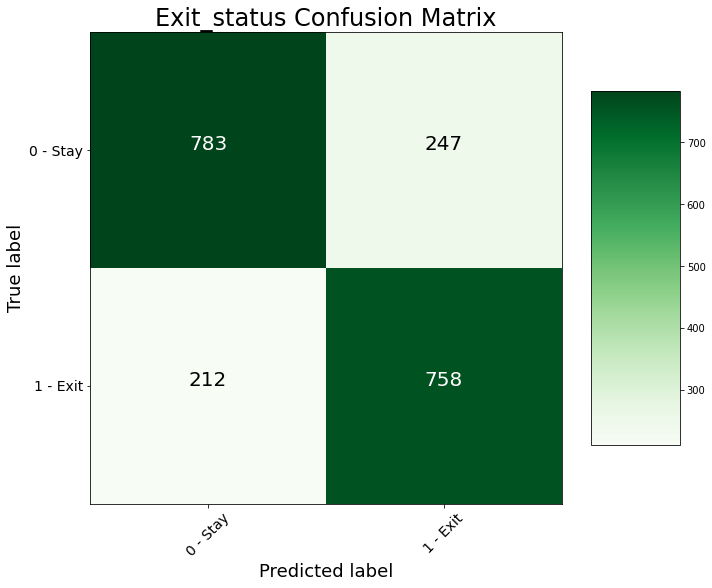

In [41]:
import itertools

def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0 - Stay', '1 - Exit'],
                      title = 'Exit_status Confusion Matrix')

In [43]:
sample = train.sample(n=1000).reset_index()
plt.figure(figsize=(6,6)) # specifying the overall grid size

test_images = []
test_labels = []
for i, row in sample.iterrows():  
    # a (32, 32, 3) image shape
    img = mpimg.imread(f'{test_dir}{row.id}')
    label = row.label
    plt.subplot(4,4,i+1)    # the number of images in the grid is 6*6 (16)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')

print('The image shape: ', img.shape)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/mosobhy/machine_learning/Cancer Detection/Task 1/Histopathologic cancer detection/test/91552c83c7e05b42dcf952e739f5013207d1c097.tif'

<Figure size 432x432 with 0 Axes>